# Object Localization with TensorFlow


![ObjectLocalizationExample.jpg](./img.jpg)


## Download and Visualize Data

In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


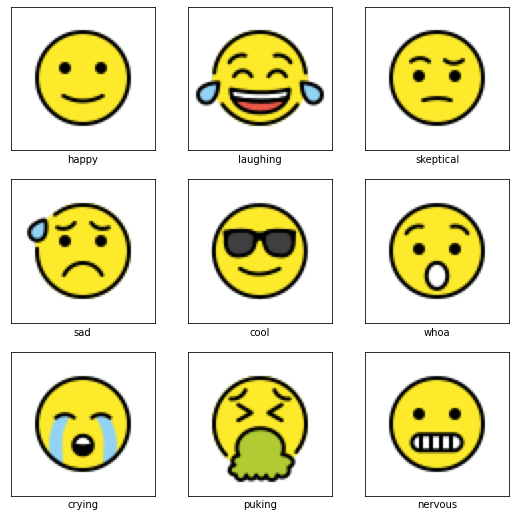

In [5]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [6]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [7]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [8]:
def create_examle():
  class_id = np.random.randint(0, 9)
  image = np.ones((144 ,144, 3)) * 255
  row = np.random.randint(0, 72)
  col = np.random.randint(0, 72)
  image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
  return image.astype('uint8'), class_id, (row + 10) /144, (col + 10) / 144

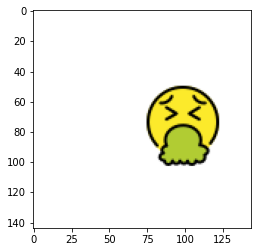

In [9]:
image, class_id, row, col = create_examle()
plt.imshow(image);

## Plot Bounding Boxes

In [10]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
  if norm:
    image *= 255.
    image = image.astype('uint8')
  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)

  row, col = gt_coords
  row *= 144
  col *= 144
  draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3)

  if len(pred_coords) == 2:
    row, col = pred_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col +52, row + 52), outline='red', width=3)
  return image



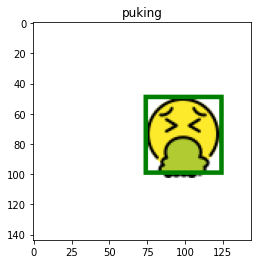

In [11]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Data Generator

In [12]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))
    y_batch = np.zeros((batch_size, 9))
    bbox_batch = np.zeros((batch_size, 2))

    for i in range(0, batch_size):
      image, class_id, row, col = create_examle()
      x_batch[i] = image / 255.
      y_batch[i, class_id] = 1.0
      bbox_batch[i] = np.array([row, col])
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

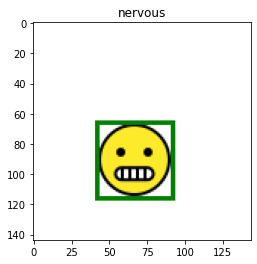

In [13]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()


## Model

In [14]:
input_ = Input(shape=(144, 144, 3), name='image')

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 142, 142, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 142, 142, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Custom Metric: IoU

In [ ]:
class IoU(tf.keras.metrics.Metric):

  def __init__(self, **kwards):
    super(IoU, self).__init__(**kwards)

    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols * 144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return x1, y1, x2, y2

    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

    iou = tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou = tf.math.divide(self.total_iou, self.num_ex)

  def result(self):
    return self.iou

  def reset_state(self):
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Compile the Model

In [ ]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy', 
        'box_out': 'mse'
    }, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy', 
        'box_out': IoU(name='iou')
    }
)

## Custom Callback: Model Testing

In [ ]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
  color = 'green' if gt == pred_class_name else 'red'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [ ]:
def test(model):
  test_datagen = data_generator(1)

  plt.figure(figsize=(16, 4))

  for i in range(0, 6):
    plt.subplot(1, 6, i + 1)
    test_model(model, test_datagen)
  plt.show()

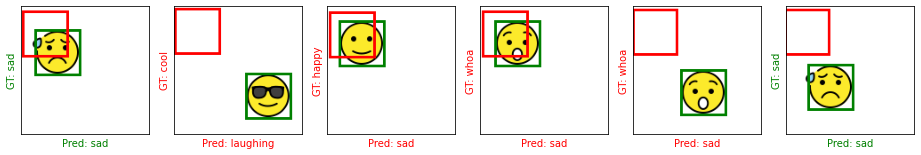

In [ ]:
test(model)

In [ ]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

## Model Training

Epoch 1/50
500/500 [==============================] - 14s 24ms/step - loss: 2.7108 - class_out_loss: 1.6019 - box_out_loss: 1.1089 - class_out_accuracy: 0.4465 - box_out_iou: 0.1088


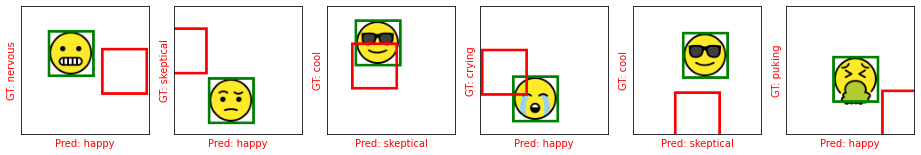

Epoch 2/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0557 - class_out_loss: 0.0151 - box_out_loss: 0.0406 - class_out_accuracy: 0.9997 - box_out_iou: 0.2426


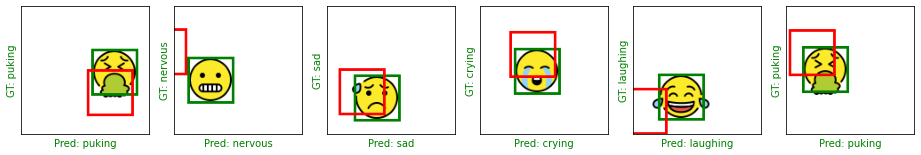

Epoch 3/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0216 - class_out_loss: 0.0044 - box_out_loss: 0.0172 - class_out_accuracy: 0.9998 - box_out_iou: 0.3821


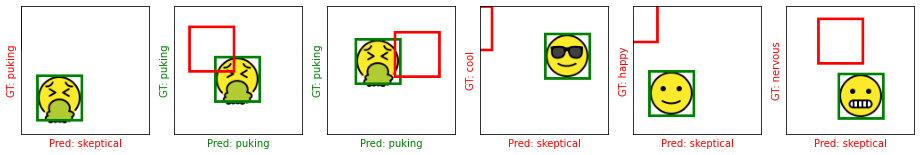

Epoch 4/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0514 - class_out_loss: 0.0338 - box_out_loss: 0.0176 - class_out_accuracy: 0.9906 - box_out_iou: 0.3887


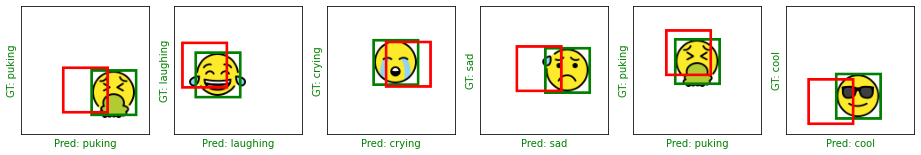

Epoch 5/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0066 - class_out_loss: 9.2898e-04 - box_out_loss: 0.0057 - class_out_accuracy: 1.0000 - box_out_iou: 0.5650


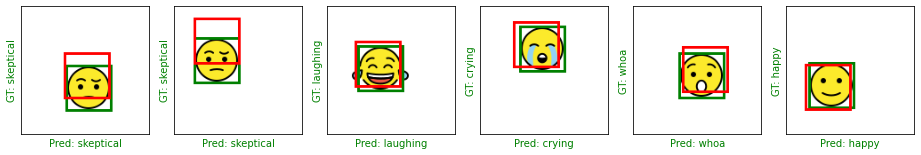

Epoch 6/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0041 - class_out_loss: 5.9506e-04 - box_out_loss: 0.0035 - class_out_accuracy: 1.0000 - box_out_iou: 0.6254


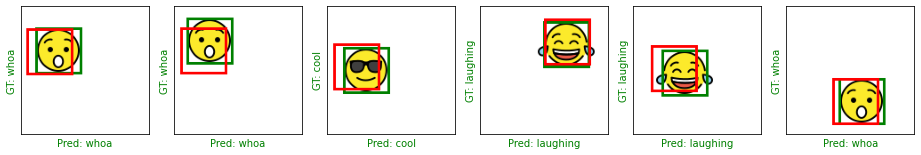

Epoch 7/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0036 - class_out_loss: 6.0990e-04 - box_out_loss: 0.0030 - class_out_accuracy: 1.0000 - box_out_iou: 0.6482


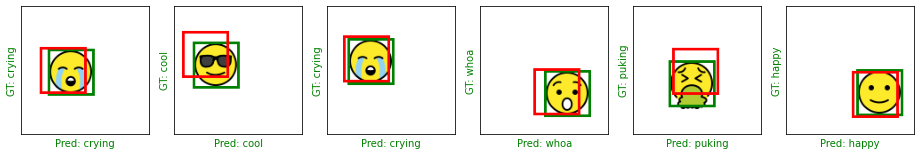

Epoch 8/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0032 - class_out_loss: 3.7029e-04 - box_out_loss: 0.0028 - class_out_accuracy: 1.0000 - box_out_iou: 0.6569


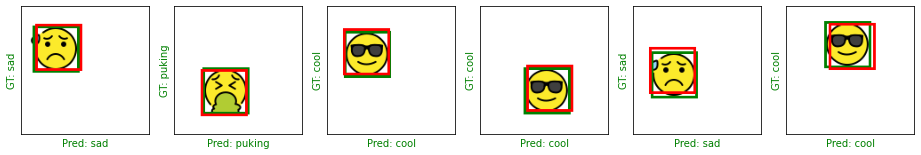

Epoch 9/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0027 - class_out_loss: 3.4170e-04 - box_out_loss: 0.0024 - class_out_accuracy: 1.0000 - box_out_iou: 0.6806


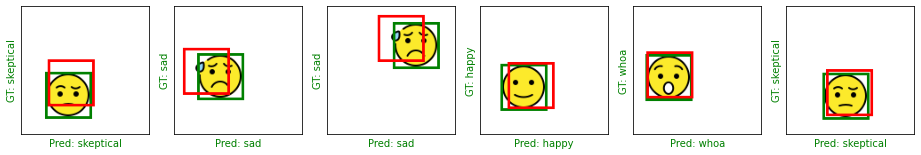

Epoch 10/50
500/500 [==============================] - 13s 25ms/step - loss: 0.0023 - class_out_loss: 4.4068e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.7073


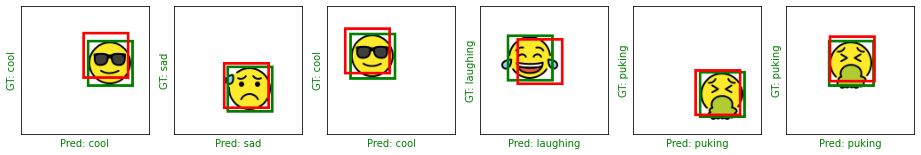

Epoch 11/50
500/500 [==============================] - 13s 25ms/step - loss: 0.0020 - class_out_loss: 3.2782e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.7214


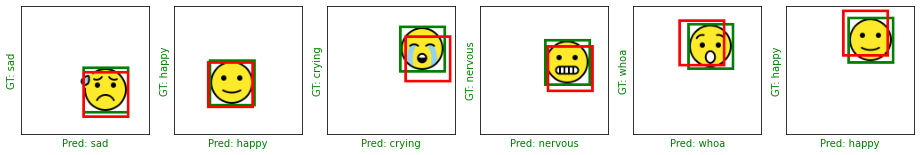

Epoch 12/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0019 - class_out_loss: 2.9698e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.7264


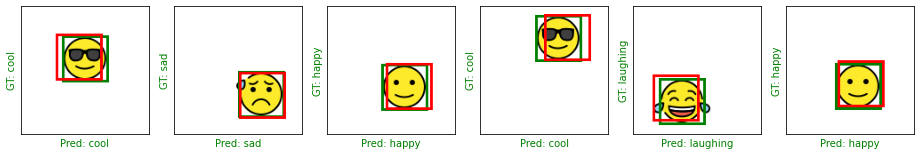

Epoch 13/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0018 - class_out_loss: 2.5964e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7293


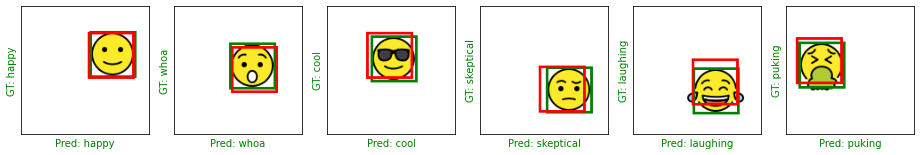

Epoch 14/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0017 - class_out_loss: 2.2599e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7347


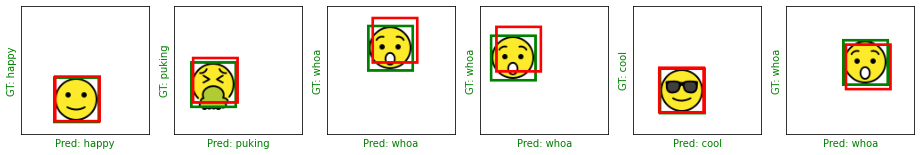

Epoch 15/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0016 - class_out_loss: 2.8017e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7423


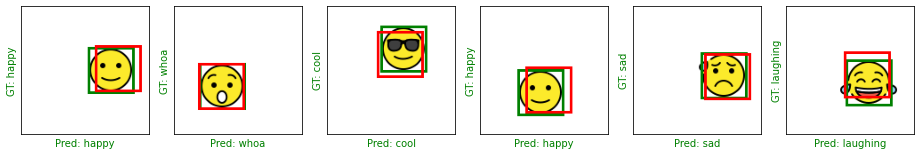

Epoch 16/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0016 - class_out_loss: 2.8411e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7463


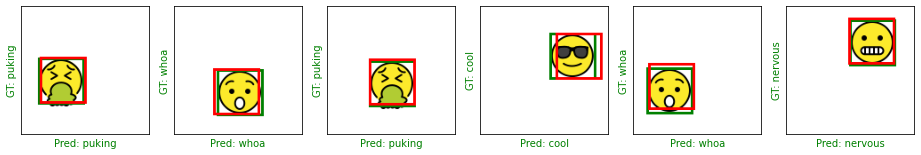

Epoch 17/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0014 - class_out_loss: 2.2589e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7534


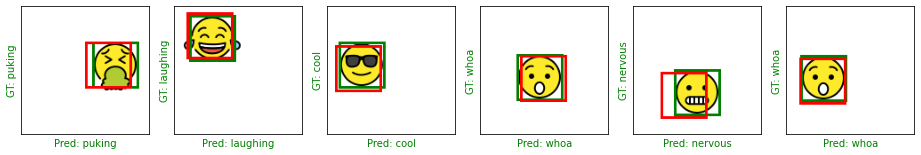

Epoch 18/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0014 - class_out_loss: 2.4101e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7555


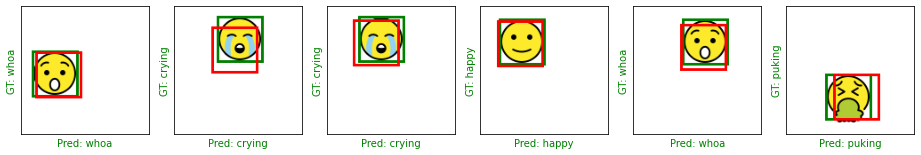

Epoch 19/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0015 - class_out_loss: 2.5941e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7550


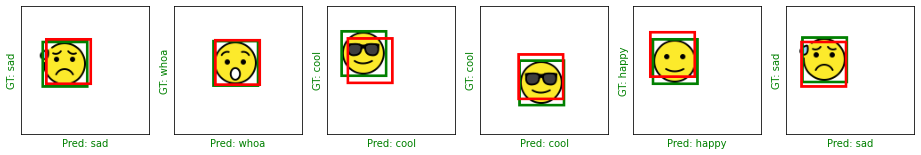

Epoch 20/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0013 - class_out_loss: 1.9122e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7595


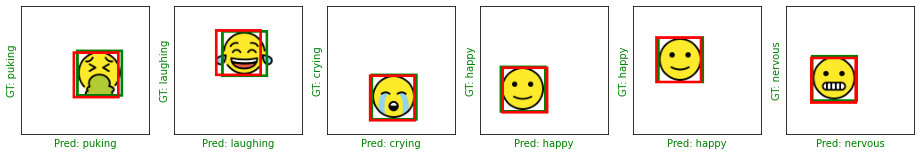

Epoch 21/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0014 - class_out_loss: 2.2956e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7593


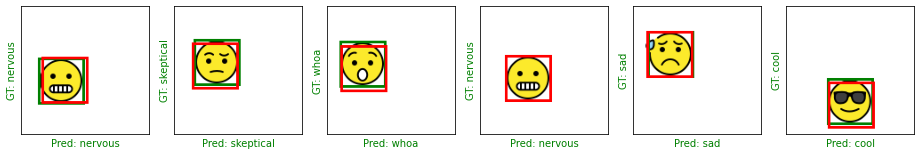

Epoch 22/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0014 - class_out_loss: 2.2015e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7576


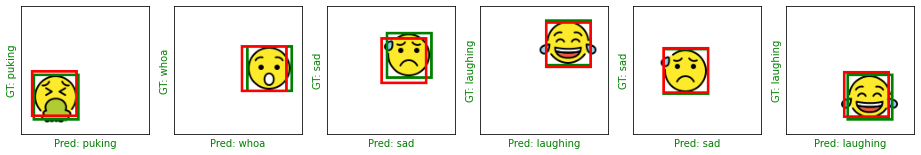

Epoch 23/50
500/500 [==============================] - 15s 29ms/step - loss: 0.0013 - class_out_loss: 1.7719e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7623


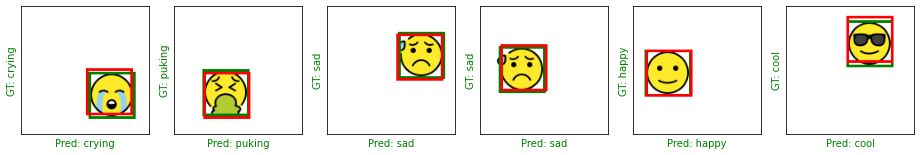

Epoch 24/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0013 - class_out_loss: 1.8501e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7646


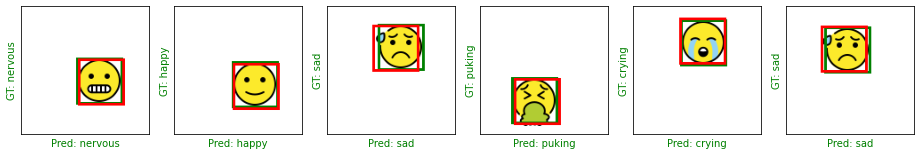

Epoch 25/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0014 - class_out_loss: 2.1492e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7597


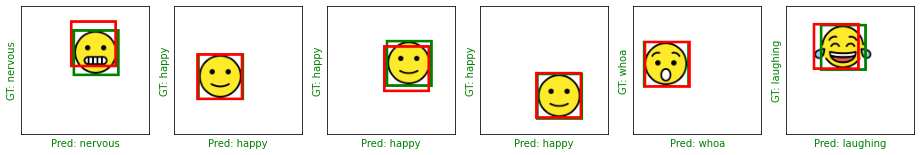

Epoch 26/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0014 - class_out_loss: 2.3127e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7626


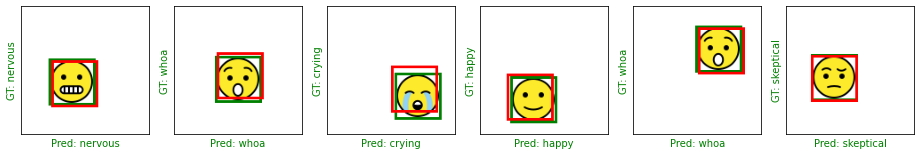

Epoch 27/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0013 - class_out_loss: 2.2828e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7627


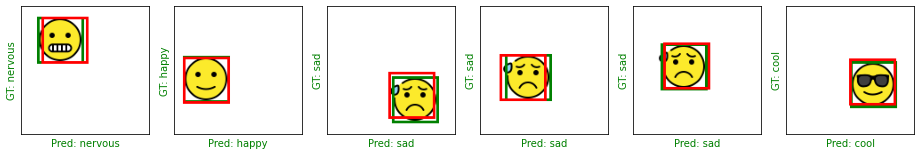

Epoch 28/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0013 - class_out_loss: 2.1575e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7664


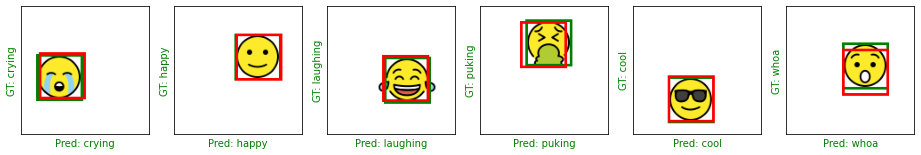

Epoch 29/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0013 - class_out_loss: 2.2210e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7661


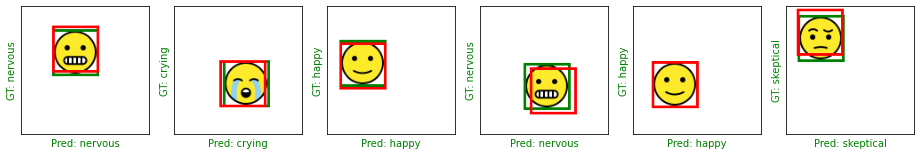

Epoch 30/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0013 - class_out_loss: 1.9700e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7665


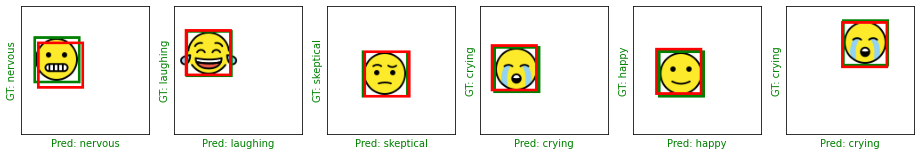

Epoch 31/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0013 - class_out_loss: 1.8736e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7602


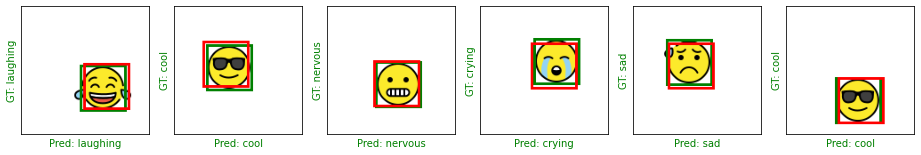

In [ ]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs = 50,
    steps_per_epoch = 500,
    callbacks=[
               ShowTestImages(), 
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]

)